#how to clean data:


In [ ]:
%%capture
!pip install biopython
!pip install biopandas

In [ ]:
import os
import pandas as pd
import csv
import requests
import numpy as np
from Bio import PDB
from Bio.PDB import PDBParser
import tensorflow as tf
import re

In [ ]:
csv_path = "/content/drive/MyDrive/pdb_entry_files.csv"
df = pd.read_csv(csv_path)

#first delete nucliotides only, those who are NMR, and seperate the EM complexes in another file

In [ ]:
def save_and_remove_data(dataframe, csv_path):
    # Remove rows with 'nuc' in the second column
    dataframe = dataframe[dataframe.iloc[:, 1] != 'nuc']

    # Remove rows with 'NMR' in the third column
    dataframe = dataframe[dataframe.iloc[:, 2] != 'NMR']

    # Save the removed rows with 'EM' in the third column to a new CSV file
    em_rows = dataframe[dataframe.iloc[:, 2] == 'EM']
    em_rows.to_csv('em_rows.csv', index=False)

    # Remove rows with 'EM' in the third column
    dataframe = dataframe[dataframe.iloc[:, 2] != 'EM']

    # Save the rows with 'prot-nuc' in the second column to a new CSV file
    prot_nuc_rows = dataframe[dataframe.iloc[:, 1] == 'prot-nuc']
    prot_nuc_rows.to_csv('prot_nuc_rows.csv', index=False)

    # Remove rows with 'prot-nuc' in the second column
    dataframe = dataframe[dataframe.iloc[:, 1] != 'prot-nuc']

    # Save the modified DataFrame to a new CSV file
    dataframe.to_csv(csv_path, index=False)

    return dataframe

# Read the original CSV file into a DataFrame
original_csv_path = "/content/drive/MyDrive/pdb_entry_files.csv"
df = pd.read_csv(original_csv_path)

# Call the function to save EM rows, 'prot-nuc' rows, remove 'nuc', 'NMR', 'EM', and 'prot-nuc' rows
modified_df = save_and_remove_data(df, 'modified_data.csv')

# Now, the 'modified_df' DataFrame contains the desired modifications and is saved in 'modified_data.csv'


In [ ]:
#dont forget to remove the first row in all the dataset
prot_EM = '/content/em_rows.csv'
prot_nuc = '/content/prot_nuc_rows.csv'
prot_csv = '/content/modified_data.csv'

df = pd.read_csv(prot_csv)

In [ ]:
df

,100d,nuc,diffraction
0,101m,prot,diffraction
1,102l,prot,diffraction
2,102m,prot,diffraction
3,103l,prot,diffraction
4,103m,prot,diffraction
...,...,...,...
166359,9rsa,prot,diffraction
166360,9rub,prot,diffraction
166361,9wga,prot,diffraction
166362,9xia,prot,diffraction


#note:
the number of proteins are nearly 167k

In [ ]:
import csv

def create_prot_name_list(csv_path):
    prot_list = []
    with open(csv_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            prot_list.append(row[0])
    return prot_list

protein_names = create_prot_name_list(prot_csv)

#download the pdb files

In [ ]:
import os
import requests

class PDBDownloader:
    def __init__(self, destination_path):
        self.destination_path = destination_path

    def download_pdb(self, protein_name_list):
        for protein_name in protein_name_list:
            filename = f"{protein_name}.pdb"
            file_path = os.path.join(self.destination_path, filename)

            # Check if the file already exists in the destination path
            if os.path.exists(file_path):
                print(f"File already exists for {protein_name}, skipping download.")
                continue

            url = f"https://files.rcsb.org/download/{protein_name}.pdb"

            try:
                response = requests.get(url)
                response.raise_for_status()
                pdb_content = response.text

                # Check if the response contains the PDB content
                if "HEADER    " not in pdb_content:
                    print(f"No PDB file found for {protein_name}")
                    continue

                with open(file_path, "w") as file:
                    file.write(pdb_content)

                print(f"Downloaded PDB file for {protein_name}")
            except requests.HTTPError as e:
                print(f"Failed to download PDB file for {protein_name}")
                print(f"HTTP Error: {e}")
            except Exception as e:
                print(f"Failed to download PDB file for {protein_name}")
                print(f"Error: {e}")

# Example usage
downloader = PDBDownloader(destination_path="/content/drive/MyDrive/NewPDBFiles")
protein_names = protein_names
downloader.download_pdb(protein_names)


File already exists for 100d, skipping download.
File already exists for 101m, skipping download.
File already exists for 102l, skipping download.
File already exists for 102m, skipping download.
File already exists for 103l, skipping download.
File already exists for 103m, skipping download.
File already exists for 104l, skipping download.
File already exists for 104m, skipping download.
File already exists for 105m, skipping download.
File already exists for 106m, skipping download.
File already exists for 107l, skipping download.
File already exists for 107m, skipping download.
File already exists for 108l, skipping download.
File already exists for 108m, skipping download.
File already exists for 109l, skipping download.
File already exists for 109m, skipping download.
File already exists for 10gs, skipping download.
File already exists for 110l, skipping download.
File already exists for 110m, skipping download.
File already exists for 111l, skipping download.
File already exists 

KeyboardInterrupt: ignored

# eliminate the low resolutions and the ones that are not X-Rey, as well as the DNA files since it might confuse the model becuase of the shared letters that dont mean the same thing (in theory the model should be able to relize this but thats not part of our discussion).


In [ ]:
#RESOLUTION
def extract_resolution(pdb_file_path):
    with open(pdb_file_path, 'r') as pdb_file:
        for line in pdb_file:
            match = re.match(r'REMARK\s+2\s+RESOLUTION\.\s+(\d+\.\d+)\s+ANGSTROMS\.', line)
            if match:
                resolution_str = match.group(1)
                try:
                    resolution = float(resolution_str)
                    return resolution
                except ValueError:
                    print("Error: Resolution information is not in a valid numerical format.")
                    return None

    print(f"Resolution information not found in {pdb_file_path}.")
    return None

#EXPERIMENT TYPE
def extract_experiment_type(pdb_file_path):
    with open(pdb_file_path, 'r') as pdb_file:
        for line in pdb_file:
            if line.startswith('REMARK 200  EXPERIMENT TYPE'):
                experiment_type = line.split(':')[1].strip()
                return experiment_type

    print("Experiment type information not found.")
    return None

#DNA FILES
def remove_pdb_files_with_header(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith('.pdb'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as pdb_file:
                lines = pdb_file.readlines()
                if any(line.startswith('HEADER    DNA') for line in lines):
                    print(f"Removing file: {filename}")
                    os.remove(file_path)

def delete_files_not_meeting_criteria(directory_path, threshold_resolution, target_experiment_type):
    num_deleted_files = 0  # Initialize the counter for deleted files
    for filename in os.listdir(directory_path):
        if filename.endswith(".pdb"):
            pdb_file_path = os.path.join(directory_path, filename)
            resolution = extract_resolution(pdb_file_path)
            experiment_type = extract_experiment_type(pdb_file_path)

            if resolution is not None and experiment_type is not None:
                # Check if the file meets any of the criteria
                if resolution < threshold_resolution or experiment_type != target_experiment_type:
                    print(f"Deleting file: {pdb_file_path} with resolution {resolution:.2f} Å and experiment type {experiment_type}")
                    os.remove(pdb_file_path)
                    num_deleted_files += 1  # Increment the counter for deleted files
                else:
                    # If the file passes the resolution and experiment type criteria,
                    # check if it also has the 'HEADER DNA' line, and remove it.
                    with open(pdb_file_path, 'r') as pdb_file:
                        lines = pdb_file.readlines()
                    if any(line.startswith('HEADER    DNA') for line in lines):
                        print(f"Removing file: {pdb_file_path}")
                        os.remove(pdb_file_path)
                        num_deleted_files += 1  # Increment the counter for deleted files

    print(f"Total files deleted: {num_deleted_files}")

# Replace 'path/to/your/directory' with the actual directory path containing the PDB files.
directory_path = "/content/drive/MyDrive/NewPDBFiles/"
threshold_resolution = 2.0  # Set the threshold resolution below which files will be deleted.
target_experiment_type = "X-ray diffraction"  # Set the desired experiment type.

delete_files_not_meeting_criteria(directory_path, threshold_resolution, target_experiment_type)


Resolution information not found in /content/drive/MyDrive/NewPDBFiles/filtered.pdb.
Experiment type information not found.
Resolution information not found in /content/drive/MyDrive/NewPDBFiles/103d.pdb.
Experiment type information not found.
Resolution information not found in /content/drive/MyDrive/NewPDBFiles/104d.pdb.
Experiment type information not found.
Resolution information not found in /content/drive/MyDrive/NewPDBFiles/105d.pdb.
Experiment type information not found.
Resolution information not found in /content/drive/MyDrive/NewPDBFiles/106d.pdb.
Experiment type information not found.
Resolution information not found in /content/drive/MyDrive/NewPDBFiles/107d.pdb.
Experiment type information not found.
Resolution information not found in /content/drive/MyDrive/NewPDBFiles/108d.pdb.
Experiment type information not found.
Resolution information not found in /content/drive/MyDrive/NewPDBFiles/124d.pdb.
Experiment type information not found.
Resolution information not found in 

# now, after we cleaned up our downloaded data, we can move on with building a csv for sequences and a json file for structure

In [ ]:
#extract the sequences: similar to the phase 1

class SequenceBuilder:
    def __init__(self, folder_path):
        self.folder_path = folder_path

    def extract_sequence_from_pdb(self, file_path):
        parser = PDB.PDBParser(QUIET=True)
        structure = parser.get_structure("temp", file_path)
        model = structure[0]
        seq = ""

        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue):
                    try:
                        seq += PDB.Polypeptide.three_to_one(residue.get_resname())
                    except KeyError:
                        seq += 'X'  # For unknown residues, use 'X' as a placeholder
                else:
                    seq += 'X'  # For non-amino acid residues, use 'X' as a placeholder
        return seq

    def sequence_builder(self):
        sequences = {}
        data = []

        for filename in os.listdir(self.folder_path):
            file_path = os.path.join(self.folder_path, filename)
            if os.path.isfile(file_path) and file_path.lower().endswith('.pdb'):  # Only process PDB files
                sequence_name = os.path.splitext(filename)[0]  # Use filename (without extension) as sequence name
                sequence = self.extract_sequence_from_pdb(file_path)
                sequences[sequence_name] = [sequence, filename]

        # Build a DataFrame
        for key, value in sequences.items():
            data.append([key, value[0]])
        df = pd.DataFrame(data, columns=['seq name', 'seq'])
        return df


In [ ]:
# dont use it if you already crated the csv for sequences
# Define the folder path containing your PDB files
folder_path = "/content/drive/MyDrive/NewPDBFiles"

# Create an instance of the SequenceBuilder class
sequence_builder = SequenceBuilder(folder_path)
# Call the sequence_builder method to get the DataFrame with sequences
df_sequences = sequence_builder.sequence_builder()
# Save the DataFrame to a CSV file in /content/drive/MyDrive
output_csv_path = "/content/drive/MyDrive/sequences.csv"
df_sequences.to_csv(output_csv_path, index=False)

print("DataFrame saved to CSV:", output_csv_path)

/usr/local/lib/python3.10/dist-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/Poly

DataFrame saved to CSV: /content/drive/MyDrive/sequences.csv


# the extraction currently working with

In [ ]:
from Bio import SeqIO
#FOR SOME REASON: WE CANT READ DNA PDB FILES; WE HAVE TO SKIP THEM
def extract_amino_acid_sequence(pdb_file_path):
    sequences = []

    with open(pdb_file_path, "r") as handle:
        for record in SeqIO.parse(handle, "pdb-seqres"):
            sequences.append(str(record.seq))

    return sequences

def read_pdb_files_from_folder(folder_path):
    all_sequences = []

    # List all files in the folder
    pdb_files = [file for file in os.listdir(folder_path) if file.endswith(".pdb")]

    # Loop through each PDB file
    for pdb_file in pdb_files:
        pdb_file_path = os.path.join(folder_path, pdb_file)
        sequences = extract_amino_acid_sequence(pdb_file_path)
        all_sequences.extend(sequences)

    return all_sequences

def save_sequences_to_text_file(sequences, output_file):
    with open(output_file, "w") as file:
        for idx, sequence in enumerate(sequences, 1):
            file.write(f"Sequence {idx}: {sequence}\n")

# Replace "your_folder_path" with the actual path to your folder containing the PDB files.
folder_path = "/content/drive/MyDrive"
amino_acid_sequences = read_pdb_files_from_folder(folder_path)

# Replace "output_file.txt" with the desired name for your output text file.
output_file = "output_file.txt"
save_sequences_to_text_file(amino_acid_sequences, output_file)


# backbone coordinates extraction: C, CA, N

In [ ]:
import os
import json
from Bio.PDB import PDBParser

def extract_backbone_coordinates(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_file)

    backbone_coordinates = {}
    for model in structure:
        for chain in model:
            chain_id = chain.get_id()
            backbone_coordinates[chain_id] = {}

            for residue in chain:
                if residue.get_id()[0] != " " or residue.get_resname() == "HOH":
                    continue

                residue_id = residue.get_id()[1]
                backbone = residue.get_unpacked_list()[0:3]  # N, CA, C atoms
                backbone_coordinates[chain_id][residue_id] = [list(atom.get_vector()) for atom in backbone]

    return backbone_coordinates

def process_pdb_folder(folder_path):
    pdb_files = [f for f in os.listdir(folder_path) if f.endswith('.pdb')]
    pdb_data = {}

    for pdb_file in pdb_files:
        pdb_path = os.path.join(folder_path, pdb_file)
        pdb_name = os.path.splitext(pdb_file)[0]
        pdb_data[pdb_name] = extract_backbone_coordinates(pdb_path)

    return pdb_data

def save_json(data, output_file):
    with open(output_file, 'w') as json_file:
        json.dump(data, json_file, indent=4)

if __name__ == "__main__":
    pdb_folder_path = "/content/drive/MyDrive/NewPDBFiles"
    # name of the file
    output_json_file = "output.json"

    extracted_data = process_pdb_folder(pdb_folder_path)
    save_json(extracted_data, output_json_file)


In [ ]:
extracted_data["1a23"]

{'A': {1: [[123.06500244140625, 15.24899959564209, -0.9160000085830688],
   [124.38099670410156, 15.53600025177002, -0.2759999930858612],
   [125.44300079345703, 14.640999794006348, -0.8600000143051147]],
  2: [[126.51599884033203, 15.267000198364258, -1.246999979019165],
   [127.66200256347656, 14.564000129699707, -1.812999963760376],
   [128.84300231933594, 14.946999549865723, -0.9399999976158142]],
  3: [[129.02699279785156, 14.14900016784668, 0.07400000095367432],
   [130.09100341796875, 14.322999954223633, 1.1260000467300415],
   [129.6230010986328, 15.359999656677246, 2.1429998874664307]],
  4: [[129.2259979248047, 14.92300033569336, 3.3259999752044678],
   [128.76300048828125, 15.890000343322754, 4.377999782562256],
   [129.5570068359375, 15.67300033569336, 5.676000118255615]],
  5: [[130.86099243164062, 15.637999534606934, 5.552000045776367],
   [131.76100158691406, 15.456999778747559, 6.736000061035156],
   [131.34100341796875, 14.21399974822998, 7.5370001792907715]],
  6: [[1

# plot the backbone

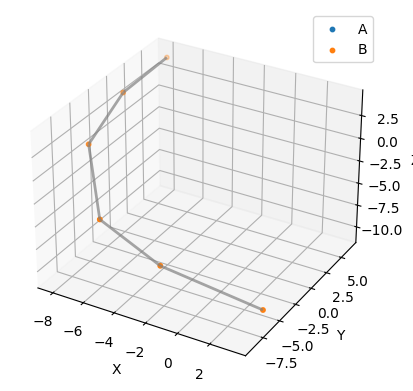

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def plot_protein_backbone_with_lines(backbone_coordinates):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for chain_id, residue_data in backbone_coordinates.items():
        x_coords, y_coords, z_coords = [], [], []
        atom_sequence = []

        for residue_id, coordinates in residue_data.items():
            x, y, z = coordinates[0]  # Take the x, y, z coordinates from the first atom (N atom)
            x_coords.append(x)
            y_coords.append(y)
            z_coords.append(z)

            atom_sequence.append(coordinates)

        ax.scatter(x_coords, y_coords, z_coords, label=chain_id, s=10)  # Set the size of dots with the 's' parameter

        # Connect neighboring atoms with lines in the correct order
        lines = [[atom_sequence[i][0], atom_sequence[i+1][0]] for i in range(len(atom_sequence)-1)]
        lc = Line3DCollection(lines, linewidths=2.0, colors='grey', alpha=0.7)  # Set the thickness of lines with 'linewidths'
        ax.add_collection3d(lc)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

# Example usage:
pdb_file = "176d"  # Replace with the specific PDB file you want to plot
backbone_coordinates = extracted_data[pdb_file]
plot_protein_backbone_with_lines(backbone_coordinates)
